In [1]:
import sys
import re

from bisect import *

from Bio import SeqIO

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import Image

In [2]:
def get_reference_len(fname):
    return np.sum([len(seq.seq) for seq in SeqIO.parse(fname, 'fasta')])

def get_scaffolds_len(fname):
    lens = [len(seq.seq) for seq in SeqIO.parse(fname, 'fasta')]
    return np.sort(lens)[::-1]

def calc_sums(lens):
    sums = np.zeros((len(lens)))
    sums[0] = lens[0]
    
    for i in range(1, len(lens)):
        sums[i] = lens[i] + sums[i-1]
    
    return sums

def find_ge(a, x):
    i = bisect_left(a, x)
    if i != len(a):
        return i
    raise ValueError

def plot_ngx(lens, sums, ref_len):
    res = list()
    try:
        for i in range(1, 101):
            percent_len = 1.*i/100*ref_len
            idx = find_ge(sums, percent_len)
            scaff_len = lens[idx]
            res.append(scaff_len)
    except:
        pass
    
    plt.figure(figsize=(10,7))
    plt.step(range(1, len(res)+1), res)

In [3]:
ref_len = get_reference_len('data/reference.fasta')
scaff_lens = get_scaffolds_len('data/A.fasta')
scaff_sums = calc_sums(scaff_lens)

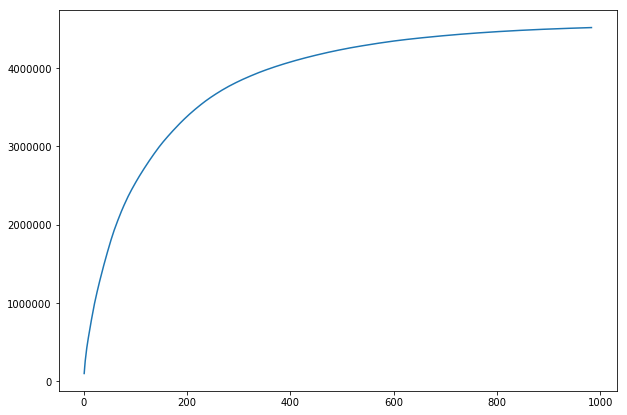

In [4]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(scaff_sums)+1), scaff_sums)

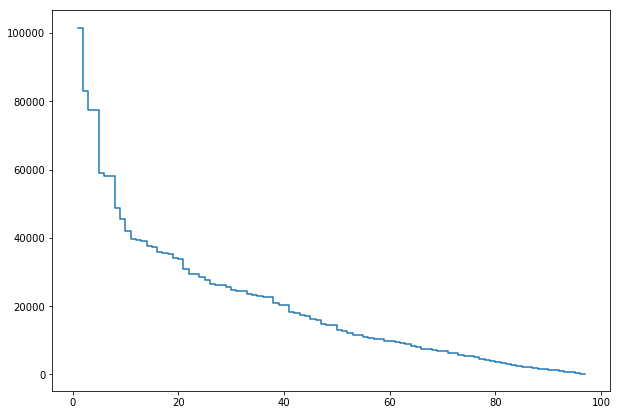

In [5]:
plot_ngx(scaff_lens, scaff_sums, ref_len)

На первый взгляд, если судить по NGx, то лучше всего сборка D.

![title](img/ngx.png)

Но если посмотреть на GC-content и общую длину сборки и сравнить с референсом, то можно заметить что длина почти в 2 раза больше чем референсная и GC-content сильно отличается. 

![title](img/gc.png)
![title](img/len.png)

Так же, косвенно, можно судить по числу найденных генов (которое очень мало).

![title](img/genes.png)

Все это склоняет ко мнению, что сборка D вообще не от организма референса или других сборок.

Выбросив D из анализа, наибольшее внимание привлекают сборки C и E. У них наилучшее значение NGx, совпадение по GC и количеству найденных генов. Они настолько похожи, что почти по всем параметрам совпадают и трудно выделить наилучшую, возможно что С чуть-чуть качественнее собрана.

Если отбросить референс, то вопрос что делать со сборкой D становится сложнее. С одной стороны, для других сборок могли применять неподходящую тулу, которая их собрала по эвристикам, что неверно работают для целевого организма, а для D выбрали подходящий и собрали качественно.  Поэтому стоит внимательнее изучить сборку D и пару C-E

In [6]:
MAX_LEN = sys.maxint

class TreeNode:
    node_count = 0

    def __init__(self, start=0, end=MAX_LEN):
        self.identifier = TreeNode.node_count
        TreeNode.node_count += 1

        self.suffix_link = None
        self.edges = {}
        self.parent = None

        self.seq_id = 0
        self.start = start
        self.end = end

    def add_child(self, key, start, end):
        child = TreeNode(start=start, end=end)
        child.parent = self
        self.edges[key] = child
        return child

    def add_node_as_child(self, key, node):
        node.parent = self
        self.edges[key] = node

    def edge_length(self, current_index):
        return min(self.end, current_index + 1) - self.start


class SuffixTree:
    def __init__(self):
        self.root = TreeNode()
        self.whole_seq = ''
        self.seq_count = 0
        self.leaves = []

    def append_sequence(self, whole_seq):
        start_index = len(self.whole_seq)
        idx = self.seq_count

        whole_seq += '@' + str(idx)

        self.whole_seq += whole_seq
        self.seq_count += 1

        active_node = self.root
        active_edge = 0
        active_length = 0

        remainder = 0

        new_leaves = []

        for index in range(start_index, len(self.whole_seq)):
            previous_node = None
            remainder += 1
            while remainder > 0:
                if active_length == 0:
                    active_edge = index

                if self.whole_seq[active_edge] not in active_node.edges:
                    leaf_node = active_node.add_child(self.whole_seq[active_edge], index, MAX_LEN)

                    leaf_node.seq_id = 1 << idx
                    new_leaves.append(leaf_node)

                    #link suffix node
                    if previous_node is not None:
                        previous_node.suffix_link = active_node
                    previous_node = active_node
                else:
                    next_node = active_node.edges[self.whole_seq[active_edge]]

                    next_edge_length = next_node.edge_length(index)
                    if active_length >= next_node.edge_length(index):
                        active_edge += next_edge_length
                        active_length -= next_edge_length
                        active_node = next_node
                        continue

                    if self.whole_seq[next_node.start + active_length] == self.whole_seq[index]:
                        active_length += 1
                        if previous_node is not None:
                            previous_node.suffix_link = active_node
                        break

                    splitted = active_node.add_child(
                        self.whole_seq[active_edge],
                        next_node.start,
                        next_node.start + active_length
                    )
                    next_node.start += active_length
                    splitted.add_node_as_child(self.whole_seq[next_node.start], next_node)
                    leaf_node = splitted.add_child(self.whole_seq[index], index, MAX_LEN)
                    leaf_node.seq_id = 1 << idx
                    new_leaves.append(leaf_node)

                    if previous_node is not None:
                        previous_node.suffix_link = splitted
                    previous_node = splitted

                remainder -= 1

                if active_node == self.root and active_length > 0:
                    active_length -= 1
                    active_edge = index - remainder + 1
                else:
                    active_node = active_node.suffix_link if active_node.suffix_link is not None else self.root

        for leaf in new_leaves:
            leaf.end = len(self.whole_seq)
        self.leaves.extend(new_leaves)

    def find_mums(self):
        id_mask = (1 << self.seq_count) - 1

        ancestors = []

        for leaf in self.leaves:
            node = leaf
            while node.parent is not None:
                if node.seq_id != id_mask:
                    node.parent.seq_id |= node.seq_id
                    node = node.parent
                else:
                    ancestors.append(node)
                    break

        mums = {''}
        max_len = 0

        for anc in ancestors:
            mum = ''
            node = anc
            while node.parent is not None:
                label = self.whole_seq[node.start:node.end]
                mum = label + mum
                node = node.parent
            mum = re.sub(r'(.*?)\$?\d*@', r'\1', mum) #remove uniq ending
            if len(mum) > max_len:
                max_len = len(mum)
                mums = {mum}
            elif len(mum) == max_len and mum not in mums:
                mums.add(mum)

        return mums

NameError: name 'MAX_LEN' is not defined

In [7]:
def read_ref_and_assembly():
    assembly = str([seq for seq in SeqIO.parse('data/mum_detection/assembly_easy.fasta', 'fasta')][0].seq)
    ref = str([seq for seq in SeqIO.parse('data/mum_detection/reference_easy.fasta', 'fasta')][0].seq)
    
    return (ref, assembly)

In [8]:
ref, assembly = read_ref_and_assembly()

In [9]:
suffix_tree = SuffixTree()
suffix_tree.append_sequence(ref)
suffix_tree.append_sequence(assembly)

print suffix_tree.find_mums()

NameError: name 'SuffixTree' is not defined